Final Project - Deep Learning

---
* RM350785 Alexandra Maria Rodrigues Marques Figueira
* RM352122 Guilherme Ruy
* RM352152 Henrique da Silva Dergado
---

Conjunto de dados está disponível no link abaixo:
https://drive.google.com/drive/folders/1OTU650tmFmeyARV5-lYW7yNacVWPxvOJ


A empresa deseja um modelo de Deep Learning que seja um ‘perseguidor de tendencia’, ou seja,
se o papel sobe o modelo deve comprar, se o papel desce o modelo deve vender.
 Para isso a QuantumFinance contratou economistas que fizerem a rotulagem dos dados baseado
no valor de fechamento dos ativos. Inicialmente foi feita uma suavização dos preços de
fechamento, e por se tratar de um assunto sigiloso, não foi informada a técnica de suavização
utilizada.

Objetivo: Gerar uma predição de compra ou venda para o dia seguinte baseado nos
últimos 15 dias de comportamento do mercado.

Importar as bibliotecas necessárias (tirar o comentário do SimpleRNN se formos usa-lo)

###Importações

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense, LSTM, concatenate
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array
from keras.regularizers import l2

import pickle

In [ ]:
#função para carregar as imagens
def load_and_preprocess_images_from_files(file_paths, target_size=(64, 64)):
    images = []
    for file_path in file_paths:
        img = load_img(file_path, target_size=target_size, color_mode='rgb')  # carregando imagem
        img_array = img_to_array(img)  # convertendo para array
        img_array = img_array / 255.0  # normalizando
        images.append(img_array)
    return np.array(images)

# Função para gerar os caminhos das imagens com base no DataFrame
def generate_image_paths(df, base_path):
    image_paths = []
    for idx, row in df.iterrows():
        label_str = '_1' if row['Label'] == 1 else '_-1'
        folder = 'comprar' if row['Label'] == 1 else 'vender'
        file_name = f"{row['Date']}{label_str}.png"
        file_path = os.path.join(base_path, folder, file_name)
        image_paths.append(file_path)
    return image_paths

###Treinamento dos Modelos (aqui permitimos ao usuário escolher qual das ações e empresa ele quer rodar, deixando o código mais limpo e organizado)



In [ ]:
acao = input("Digite um número de 1 a 4 para escolher qual ação quer treinar:\n1 - BBAS3.SA\n2 - CSNA3.SA\n3 - PETR4.SA\n4 - VALE3.SA\n")
while acao not in ['1', '2', '3', '4']:
  acao = input("Número inválido. Digite um número de 1 a 4 para escolher qual ação quer treinar:\n1 - BBAS3.SA\n2 - CSNA3.SA\n3 - PETR4.SA\n4 - VALE3.SA\n")

if acao == '1':
  acao = 'BBAS3.SA'
elif acao == '2':
  acao = 'CSNA3.SA'
elif acao == '3':
  acao = 'PETR4.SA'
elif acao == '4':
  acao = 'VALE3.SA'
else:
  print("Número inválido. Escolha um número de 1 a 4.")


Digite um número de 1 a 4 para escolher qual ação quer treinar:
1 - BBAS3.SA
2 - CSNA3.SA
3 - PETR4.SA
4 - VALE3.SA
5
Número inválido. Digite um número de 1 a 4 para escolher qual ação quer treinar:
1 - BBAS3.SA
2 - CSNA3.SA
3 - PETR4.SA
4 - VALE3.SA
1


In [ ]:
print("Você escolheu a ação:", acao)

Você escolheu a ação: BBAS3.SA


In [ ]:
acao_file = acao+'.zip'

if not os.path.exists(acao_file):
  # URL do arquivo ZIP no GitHub
  file_url = 'https://github.com/henriquedergado/data-science/blob/main/datasets/'+acao_file

  # Baixar o arquivo ZIP do GitHub com o nome da ação
  !wget -O {acao_file} {file_url}

  # Descompactar o arquivo ZIP
  !unzip {acao_file}
else:
  print('Este arquivo já foi importado, pode seguir para o próximo passo.')

Streaming output truncated to the last 5000 lines.
  inflating: BBAS3.SA/imagens/treino/vender/2014-01-22_-1.png  
  inflating: __MACOSX/BBAS3.SA/imagens/treino/vender/._2014-01-22_-1.png  
  inflating: BBAS3.SA/imagens/treino/vender/2010-09-08_-1.png  
  inflating: __MACOSX/BBAS3.SA/imagens/treino/vender/._2010-09-08_-1.png  
  inflating: BBAS3.SA/imagens/treino/vender/2000-07-18_-1.png  
  inflating: __MACOSX/BBAS3.SA/imagens/treino/vender/._2000-07-18_-1.png  
  inflating: BBAS3.SA/imagens/treino/vender/2014-05-09_-1.png  
  inflating: __MACOSX/BBAS3.SA/imagens/treino/vender/._2014-05-09_-1.png  
  inflating: BBAS3.SA/imagens/treino/vender/2011-08-12_-1.png  
  inflating: __MACOSX/BBAS3.SA/imagens/treino/vender/._2011-08-12_-1.png  
  inflating: BBAS3.SA/imagens/treino/vender/2017-12-05_-1.png  
  inflating: __MACOSX/BBAS3.SA/imagens/treino/vender/._2017-12-05_-1.png  
  inflating: BBAS3.SA/imagens/treino/vender/2008-04-24_-1.png  
  inflating: __MACOSX/BBAS3.SA/imagens/treino/vende

In [ ]:
# Carregar os datasets de treino e teste
train_df = pd.read_csv(acao+'/treino.csv')
train_df = train_df.dropna().drop(columns=train_df.columns[0])

test_df = pd.read_csv(acao+'/teste.csv')
test_df = test_df.dropna().drop(columns=test_df.columns[0])

# Visualizar os primeiros registros dos datasets
print(train_df.head())
print(test_df.head())

         Date     Close  Smoothed_Close  Label  Past_1_Days_Close  \
0  2000-01-24  1.062769        1.071645     -1           1.088979   
1  2000-01-26  1.087668        1.073247     -1           1.062769   
2  2000-01-27  1.064080        1.072330     -1           1.087668   
3  2000-01-28  1.036561        1.068753     -1           1.064080   
4  2000-01-31  1.035250        1.065403     -1           1.036561   

   Past_2_Days_Close  Past_3_Days_Close  Past_4_Days_Close  Past_5_Days_Close  \
0           1.079805           1.086357           1.098152           1.069322   
1           1.088979           1.079805           1.086357           1.098152   
2           1.062769           1.088979           1.079805           1.086357   
3           1.087668           1.062769           1.088979           1.079805   
4           1.064080           1.087668           1.062769           1.088979   

   Past_6_Days_Close  Past_7_Days_Close  Past_8_Days_Close  Past_9_Days_Close  \
0           1.061

Carregar imagens

In [ ]:
# Pastas base contendo as imagens de treino e teste
base_train_image_folder = acao + '/imagens/treino'
base_test_image_folder = acao + '/imagens/teste'

# Gerar os caminhos das imagens
train_image_paths = generate_image_paths(train_df, base_train_image_folder)
test_image_paths = generate_image_paths(test_df, base_test_image_folder)

# Carregar e pré-processar as imagens com base nos caminhos gerados
X_train_images = load_and_preprocess_images_from_files(train_image_paths)
X_test_images = load_and_preprocess_images_from_files(test_image_paths)

# Extrair os rótulos do DataFrame
y_train_images = train_df['Label'].values
y_test_images = test_df['Label'].values

In [ ]:
X_train_images.shape

(4735, 64, 64, 3)

**Preparação das bases de treino e teste**

In [ ]:
# Separar as features (X) e o target (Y) para o dataset de treino
X_train = train_df.drop(columns=['Label']).iloc[:, 2:].values  # Colunas de "Past_1_Days_Close" até "Past_15_Days_Close"
Y_train = train_df['Label'].values  # Coluna "Label"

# Para o dataset de teste, vamos manter a coluna 'Label'
X_test = test_df.drop(columns=['Label']).iloc[:, 2:].values  # Colunas de "Past_1_Days_Close" até "Past_15_Days_Close"
Y_test = test_df['Label'].values  # Coluna "Label"

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

X_train.shape

(4735, 16, 1)

**Normalização da base de treino e teste**

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train_norm = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_norm = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
# Separação dos dados de validação
X_val = X_test_norm[:300]
X_val_img = X_test_images[:300]
y_val = Y_test[:300]
y_val_img = y_test_images[:300]

In [ ]:
#Treina o modelo apenas se ainda não foi treinado
if not os.path.exists('modelo_'+acao+'.h5'):
  # Definindo o modelo CNN com Dropout e Regularização L2
  input_img = Input(shape=(64, 64, 3))
  x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(input_img)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.5)(x)
  x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.5)(x)
  x = Flatten()(x)
  x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
  x = Dropout(0.5)(x)
  cnn_output = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)

  cnn_model = Model(inputs=input_img, outputs=cnn_output)

  # Dados tabulares
  input_tabular = Input(shape=(X_train_norm.shape[1], X_train_norm.shape[2]))

  # LSTM para dados tabulares
  lstm = LSTM(50, return_sequences=True)(input_tabular)
  lstm = LSTM(50)(lstm)
  lstm_output = Dense(32, activation='relu')(lstm)

  # Combinar saída da CNN com os dados tabulares
  combined = concatenate([cnn_output, lstm_output])

  # Camada de saída final
  output = Dense(1, activation='tanh')(combined)

  # Definir o modelo combinado
  combined_model = Model(inputs=[input_img, input_tabular], outputs=output)
  combined_model.compile(loss='mean_squared_error', optimizer='adam')

  # Treinamento do modelo combinado
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  h1 = combined_model.fit(
      [X_train_images, X_train_norm], Y_train,
      validation_data=([X_val_img, X_val], y_val),
      epochs=20, batch_size=32, verbose=2, callbacks=[early_stopping]
  )

  # Salvar o modelo combinado
  combined_model.save('modelo_' + acao + '.h5')

  # Salvar o histórico de treinamento
  with open('history_' + acao + '.pkl', 'wb') as file_pi:
      pickle.dump(h1.history, file_pi)

else:
  print('Este modelo já foi treinado anteriormente, pode seguir para o próximo passo.')

Este modelo já foi treinado anteriormente, pode seguir para o próximo passo.


In [ ]:
# Carregar o modelo salvo
modelo_carregado = load_model('modelo_' + acao + '.h5')

# Carregar o histórico de treinamento
with open('history_' + acao + '.pkl', 'rb') as file_pi:
    history = pickle.load(file_pi)

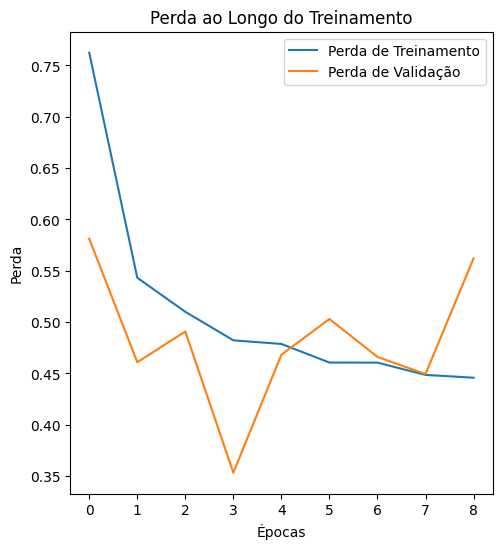

In [ ]:
# Curvas de perda e acurácia
plt.figure(figsize=(12, 6))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Perda de Treinamento')
plt.plot(history['val_loss'], label='Perda de Validação')
plt.title('Perda ao Longo do Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()

In [ ]:
# Fazer previsões com o modelo carregado
predictions = modelo_carregado.predict([X_test_images, X_test_norm])
predictions = np.where(predictions > 0, 1, -1)  # Convertendo para -1 ou 1 com base no limiar zero

38/38 [==============================] - 1s 5ms/step


              precision    recall  f1-score   support

          -1       0.91      0.90      0.91       689
           1       0.87      0.88      0.87       496

    accuracy                           0.89      1185
   macro avg       0.89      0.89      0.89      1185
weighted avg       0.89      0.89      0.89      1185



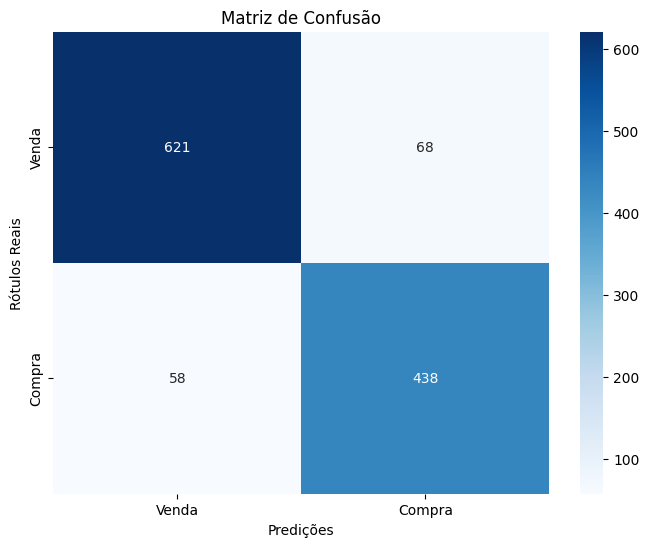

In [ ]:
print (classification_report(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions, labels=[-1, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Venda', 'Compra'], yticklabels=['Venda', 'Compra'])
plt.ylabel('Rótulos Reais')
plt.xlabel('Predições')
plt.title('Matriz de Confusão')
plt.show()